A toy application of the LFADS method.  

Contents:
1. Artificial data generation.
2. Network initialization and training.
3. Data reconstruction.
4. Visualization of the latent encoding.

### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import lfads
import utils as ut
import umap
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4, suppress=True)

sns.set_style('white', rc={'axes.spines.right': False, 'axes.spines.top': False})
sns.set_context("notebook")

%matplotlib inline

### Script parameters

In [4]:
# after network init. all data need to be input in batches of the same size given the current net implementation
batch_size = 128

# select a GPU device
icuda = 0
device = torch.device("cuda:"+str(icuda) if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


# Data

Short 30 time point signals will be encoded and reconstructed to illustrate in this toy application of a sequential autoencoder. Data were generated using the formula:  

$$ x = sin(tf+\theta)e^{tk}$$
- Each sample consists of 10 sinusoidal signals. The oscillation frequencies are the same for all samples and span the <0.5; 4> Hz range.
- Samples differ by having different phase shifts and by being modulated by different exponentials.  
- Phase shifts span the <0, $\pi$> range
- Exponential coefficients span the <-1, 1> range
- The model takes 3D inputs. Input data dimensions are $time$ x $samples$ x $frequencies$




In [5]:
sig_len = 30

# range specifications
lim_f = (0.5, 4)
lim_ph = (0, np.pi)
lim_exp = (-1, 1)

# counts of different freqs., phases and exponents used
n_f = 10
n_ph = 100
n_exp = 100

### Plot examples
The plots show how the three properties influence individual generated signals.

Frequencies


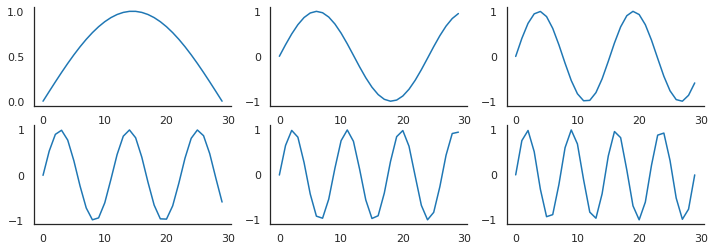

Phase shifts


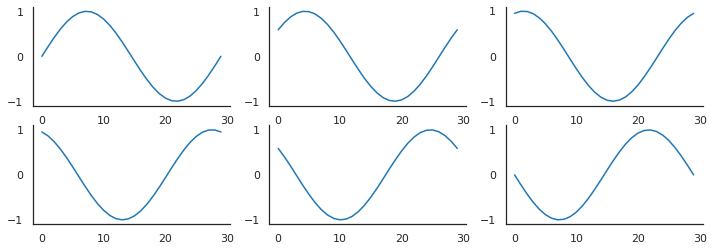

Exponential modulation


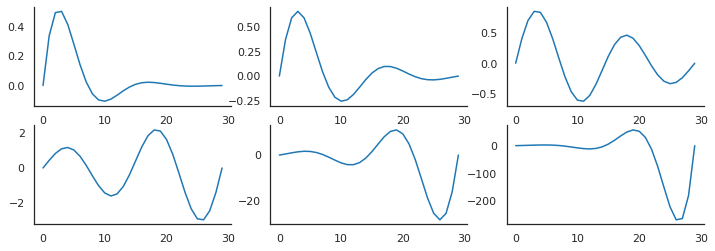

In [7]:
t = np.linspace(0, 2*np.pi, sig_len)

print('Frequencies')
plt.figure(figsize=(12, 4))
for i, f in enumerate(np.linspace(lim_f[0], lim_f[1], 6)):
    plt.subplot(2, 3, i+1)
    plt.plot(np.sin(t*f))
plt.show()

print('Phase shifts')
plt.figure(figsize=(12, 4))
for i, ph in enumerate(np.linspace(lim_ph[0], lim_ph[1], 6)):
    plt.subplot(2, 3, i+1)
    plt.plot(np.sin(t+ph))
plt.show()

print('Exponential modulation')
plt.figure(figsize=(12, 4))
for i, ex in enumerate(np.linspace(lim_exp[0], lim_exp[1], 6)):
    plt.subplot(2, 3, i+1)
    plt.plot(np.sin(t*2)*np.exp(t*ex))
plt.show()

### Generate data

Generate a sample for each point of the grid specified by phase and exponent values. Save these values for later use.

In [8]:
t = np.linspace(0, 2*np.pi, sig_len)
phases = np.linspace(lim_ph[0], lim_ph[1], n_ph)
exps = np.linspace(lim_exp[0], lim_exp[1], n_exp)
freqs = np.linspace(lim_f[0], lim_f[1], n_f)

# save each sample's phase and exponent values for later use as labels
labels = {}
labels['ph'] = np.zeros((n_ph, n_exp))
labels['exp'] = np.zeros((n_ph, n_exp))

# generate signals
sigs = np.zeros((n_ph, n_exp, n_f, sig_len))
for ip, ph in enumerate(phases):
    labels['ph'][ip, :] = ph
    for ie, ex in enumerate(exps):
        labels['exp'][:, ie] = ex
        for ifq, f in enumerate(freqs):
            sigs[ip, ie, ifq, :] = np.sin(t*f+ph)*np.exp(t*ex)
            
# variance normalization
sigs -= sigs.mean(-1, keepdims=True)
sigs /= sigs.std(-1, ddof=1, keepdims=True)

print(sigs.shape)

(100, 100, 10, 30)


Remove some samples from the training. Instead of removing random points, remove whole parts of the phase-exponent grid.

In [9]:
idx_val = np.zeros(sigs.shape, dtype=bool)
idx_val[40:60, 40:62] = True
idx_val[20:30, 20:30] = True
idx_val[75:85, 75:85] = True
idx_tr = ~idx_val
xtr = sigs[idx_tr]
xval = sigs[idx_val]
xtr = xtr.reshape(-1, sigs.shape[-2], sigs.shape[-1])
xval = xval.reshape(-1, sigs.shape[-2], sigs.shape[-1])

# match the dimension order required by pytroch GRUs
xtr = np.transpose(xtr, (2, 0, 1))
xval = np.transpose(xval, (2, 0, 1))
print(xtr.shape, xval.shape)

(30, 9360, 10) (30, 640, 10)


Divide the labels as well.

In [10]:
labels['ph_val'] = labels['ph'][idx_val[:, :, 0, 0]]
labels['ph_tr'] = labels['ph'][idx_tr[:, :, 0, 0]]
labels['exp_val'] = labels['exp'][idx_val[:, :, 0, 0]]
labels['exp_tr'] = labels['exp'][idx_tr[:, :, 0, 0]]
print(labels['ph_tr'].shape, labels['ph_val'].shape)

(9360,) (640,)


### Plot data examples


Training sample # 8623


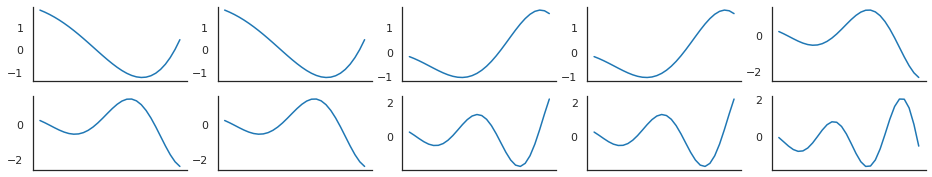

Training sample # 8379


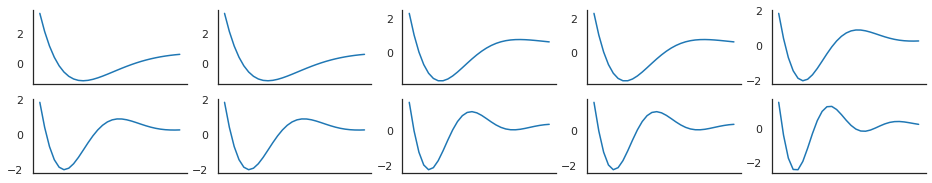

Training sample # 5117


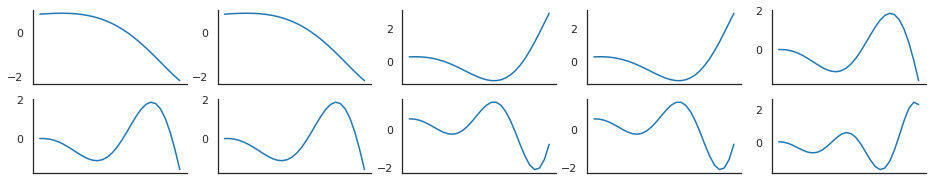

In [11]:
iplot = np.random.randint(xtr.shape[1], size=(3,))

for i in iplot:
    print('Training sample #', i)
    plt.figure(figsize=(16, 3))
    for ifq in range(len(freqs)):
        plt.subplot(2, 5, ifq+1)
        plt.plot(xtr[:, i, int(freqs[ifq])])
        plt.xticks([])
    plt.show()

### Move data to PyTorch

In [12]:
# move to pytroch
xtr = torch.tensor(xtr, dtype=torch.float, device=device)
xval = torch.tensor(xval, dtype=torch.float, device=device)

# create Dataset objects
dset_tr = lfads.SequentialDataset(xtr)
dset_val = lfads.SequentialDataset(xval)

dload_tr = DataLoader(dset_tr, batch_size=batch_size, shuffle=True, num_workers=0,
                      drop_last=True, pin_memory=False, collate_fn=lfads.collate_seq)
dload_val = DataLoader(dset_val, batch_size=batch_size, shuffle=True, num_workers=0,
                       drop_last=True, pin_memory=False, collate_fn=lfads.collate_seq)

# LFADS model

### Hyperparameters

In [15]:
# Network parameters
hype_enc = {'n_hidden' : 300, 'n_layers' : 2, 'hscale' : 0, 'in_features' : n_f}
hype_dec = {'n_hidden' : 300, 'n_layers' : 2, 'n_fact' : 10}
hypers = {'n_epochs' : 50, 'batch_size' : batch_size, 'seq_len' : sig_len,
          'drop_rate' : 0.02, 'max_grad_norm' : 100.0, 'reco_loss' : 'MSE',
          'dec' : hype_dec, 'enc' : hype_enc}

# Latent priors
hype_prior = {'mean' : 0, 'logvar' : np.log(0.1)}

# Optimizer
hype_opt = {'betas' : (0.9, 0.999), 'eps' : 1e-1, 
            'l2reg' : 0, 
            'lr_init' : 0.001, 'lr_decay' : 0.99985}

# KL loss & scheduler 
hype_kl = {'kl_warmup_start' : 3000, # input sample number at which kl warmup starts
           'kl_warmup_end' : 3500, # input sample number at whic kl warmup finishes
           'kl_min' : 0.01, # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
           'kl_max' : 0.2}

### Initialize network
It's called 'dynamo' because it's all about dynamics :>

In [17]:
dynamo = lfads.LFADS(hypers, device).to(device)    
print(dynamo)

# Number of parameters
pytorch_total_params = sum(p.numel() for p in dynamo.parameters() if p.requires_grad)
print('Trainable parameters:', pytorch_total_params)
print('Is CUDA:', next(dynamo.parameters()).is_cuda)

# Test a single input batch
with torch.no_grad():
    y, icm, icv = dynamo(dset_tr[:hypers['batch_size']].to(device))
    print(y.shape, icm.shape, icv.shape)

LFADS(
  (in_drop): Dropout(p=0.02, inplace=False)
  (enc): GRU(10, 300, num_layers=2, bidirectional=True)
  (ic_w): Linear(in_features=600, out_features=1200, bias=True)
  (enc_drop): Dropout(p=0.02, inplace=False)
  (dec): GRU(1, 300, num_layers=2)
  (dec_drop): Dropout(p=0.02, inplace=False)
  (factors): Linear(in_features=300, out_features=10, bias=True)
  (out_w): Linear(in_features=10, out_features=10, bias=True)
)
Trainable parameters: 3725230
Is CUDA: True
torch.Size([30, 128, 10]) torch.Size([128, 600]) torch.Size([128, 600])


### Optimizer, scheduler, warmup
The Adam optimizer and exponentially decaying learning rate are used.

In [19]:
optimizer = optim.Adam(dynamo.parameters(), lr=hype_opt['lr_init'], betas=hype_opt['betas'],
                       weight_decay=hype_opt['l2reg'])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=hype_opt['lr_decay'])

The KL term is introduced only after some training time.

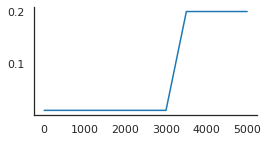

In [20]:
kl_warmup_fun = lfads.get_kl_warmup_fun(hype_kl)
plt.figure(figsize=(4, 2))
plt.plot(kl_warmup_fun(np.arange(0, 5000)))
plt.show()

### Train
The loss ramps up after the KL term grows.

In [23]:
isamples = 0
loss_tr = []
loss_val = []

t1 = time.perf_counter()
for ie in range(hypers['n_epochs']):
    
    # Training
    for ib, x in enumerate(dload_tr, 0):
        
        dynamo.zero_grad()
        
        x_rec, ic_mean, ic_logvar = dynamo(x)
        
        kl_scale = kl_warmup_fun(isamples)
        isamples += 1
        
        batch_loss = lfads.lfads_loss(x, x_rec, ic_mean, ic_logvar, 
                                torch.as_tensor(hype_prior['mean']), 
                                torch.as_tensor(hype_prior['logvar']), 
                                torch.as_tensor(kl_scale),
                                loss_type=hypers['reco_loss'])
        
        batch_loss.backward()
        loss_tr.append(batch_loss.item())
        
        nn.utils.clip_grad_norm_(dynamo.parameters(), hypers['max_grad_norm'])
        
        optimizer.step()
        scheduler.step()
    
    # Validation
    with torch.no_grad():
        for ib, x in enumerate(dload_val):
            x = x.to(device)
            x_rec, ic_mean, ic_logvar = dynamo(x)
            batch_loss = lfads.lfads_loss(x, x_rec, ic_mean, ic_logvar, 
                                    torch.as_tensor(hype_prior['mean']), 
                                    torch.as_tensor(hype_prior['logvar']), 
                                    torch.as_tensor(kl_scale),
                                    loss_type=hypers['reco_loss'])
            loss_val.append(batch_loss.item())
            
    t2 = time.perf_counter()
    print('Epoch', ie,' loss train:', loss_tr[-1], ' loss val:', loss_val[-1], 'time: ', t2-t1)
    t1 = t2

Epoch 0  loss train: 0.8647345900535583  loss val: 0.7963403463363647 time:  1.7867261350002082
Epoch 1  loss train: 0.6451941132545471  loss val: 0.5074867010116577 time:  1.7615800259991374
Epoch 2  loss train: 0.4493705928325653  loss val: 0.3504694998264313 time:  1.7681474030014215
Epoch 3  loss train: 0.3967078924179077  loss val: 0.28587278723716736 time:  1.7627353819989366
Epoch 4  loss train: 0.2885814905166626  loss val: 0.2805773913860321 time:  1.761219729000004
Epoch 5  loss train: 0.27403783798217773  loss val: 0.2965853810310364 time:  1.7662708190000558
Epoch 6  loss train: 0.22637003660202026  loss val: 0.23496641218662262 time:  1.7617929790012568
Epoch 7  loss train: 0.23018471896648407  loss val: 0.2029915601015091 time:  1.7712032219988032
Epoch 8  loss train: 0.1756013035774231  loss val: 0.16854292154312134 time:  1.7766694109996024
Epoch 9  loss train: 0.15228082239627838  loss val: 0.12879635393619537 time:  1.7798803740006406
Epoch 10  loss train: 0.158292293

## Reconstruct all, get latents and factors

In [25]:
# Prepare all signals for reconstruction
x = sigs.reshape(-1, sigs.shape[-2], sigs.shape[-1])
x = np.transpose(x, (2, 0, 1))

x = torch.tensor(x, dtype=torch.float, device=device)
ds = lfads.SequentialDataset(x)
dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0,
                      drop_last=True, pin_memory=False, collate_fn=lfads.collate_seq)

# Create objects for storing results
x_rec = torch.empty_like(x)
latent_means = torch.empty((x.shape[1], hype_enc['n_hidden']*hype_enc['n_layers']))
latent_stds = torch.empty((x.shape[1], hype_enc['n_hidden']*hype_enc['n_layers']))
factors = torch.empty((sig_len, x.shape[1], hype_dec['n_fact']))

# Reconstruct, get latents & factors
with torch.no_grad():
    for i, xbatch in enumerate(dl):
        with torch.no_grad():
            tmp = dynamo.reco_return_factors(xbatch.to(device))
        x_rec[:, i*hypers['batch_size']:(i+1)*hypers['batch_size']] = tmp[0]
        latent_means[i*hypers['batch_size']:(i+1)*hypers['batch_size']] = tmp[1]
        latent_stds[i*hypers['batch_size']:(i+1)*hypers['batch_size']] = tmp[2]
        factors[:, i*hypers['batch_size']:(i+1)*hypers['batch_size']] = tmp[3]

# Move to CPU and numpy
x = x.to("cpu").numpy()
x_rec = x_rec.detach().to("cpu").numpy()
latent_means = latent_means.detach().to("cpu").numpy()
latent_stds = latent_stds.detach().to("cpu").numpy()
factors = factors.detach().to("cpu").numpy()

# Create additional objects storing only validation set results
x_val = x[:, idx_val[:, :, 0, 0].reshape(-1)]
x_rec_val = x_rec[:, idx_val[:, :, 0, 0].reshape(-1)]
latent_means_val = latent_means[idx_val[:, :, 0, 0].reshape(-1)]
latent_stds_val = latent_stds[idx_val[:, :, 0, 0].reshape(-1)]
factors_val = factors[:, idx_val[:, :, 0, 0].reshape(-1)]

In [27]:
np.isnan(latent_means).sum()

0

### Plot reconstruction examples
Blue curves show input data and orange reconstructions.

All samples


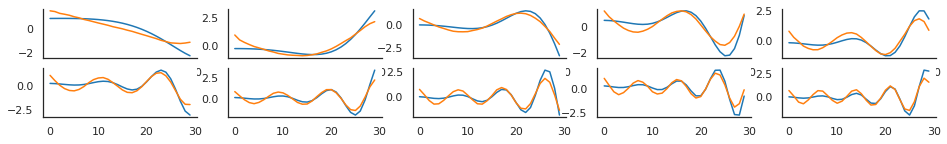

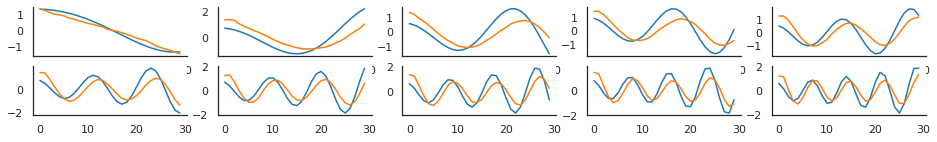

TEST only


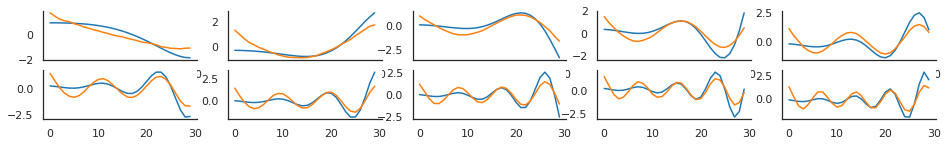

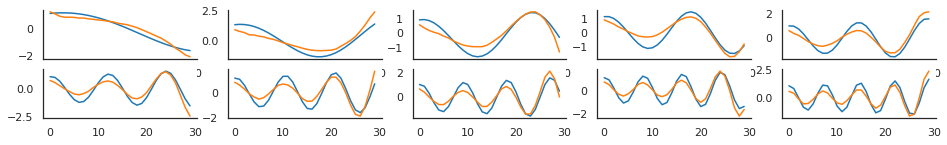

In [29]:
print('All samples')
iplot = np.random.randint(x.shape[1], size=(2,))
for i in iplot:
    plt.figure(figsize=(16, 2))
    for j in range(n_f):
        plt.subplot(2, 5, j+1)
        plt.plot(x[:, i, j])
        plt.plot(x_rec[:, i, j])
    plt.show()

print('Validation only')
iplot = np.random.randint(x_rec_val.shape[1], size=(2,))
for i in iplot:
    plt.figure(figsize=(16, 2))
    for j in range(n_f):
        plt.subplot(2, 5, j+1)
        plt.plot(x_val[:, i, j])
        plt.plot(x_rec_val[:, i, j])
    plt.show()

# Visualize the latent encoding
[Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426) (UMAP; [library](https://umap-learn.readthedocs.io/en/latest/)) is used to reduce the dimensionality of the latent means to 2D. Each point in the scatter plot represens the latent encoding of a single sample. The structure of the latent space can be clearly observed by coloring each point according to its phase or exponent value. The test samples which were extracted from specific parts of the phase/exponent grid maintain their relative positions.

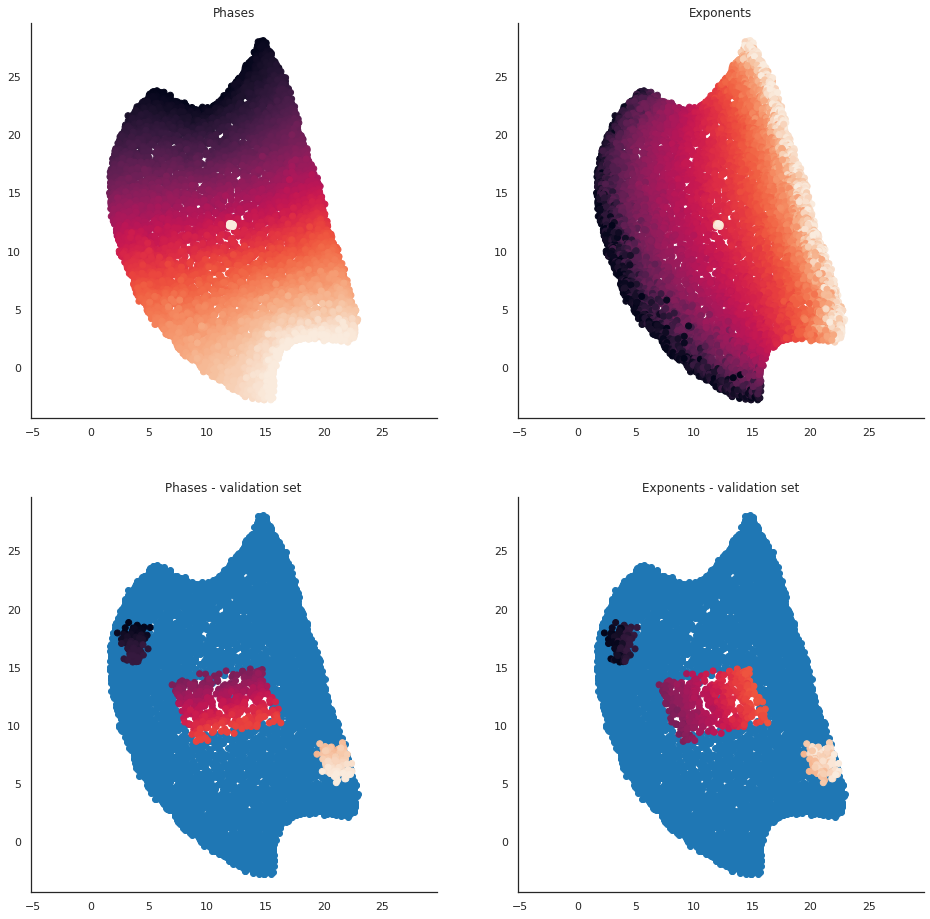

In [37]:
reducer = umap.UMAP(n_neighbors=50, min_dist=1)
embedding = reducer.fit_transform(latent_means)
emb_val = reducer.transform(latent_means_val)
plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels['ph'].reshape(-1))
plt.title('Phases')
plt.gca().set_aspect('equal', 'datalim')
plt.subplot(222)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels['exp'].reshape(-1))
plt.title('Exponents')
plt.gca().set_aspect('equal', 'datalim')
plt.subplot(223)
plt.scatter(embedding[idx_tr[:, :, 0, 0].reshape(-1), 0], 
            embedding[idx_tr[:, :, 0, 0].reshape(-1), 1])
plt.scatter(emb_val[:, 0], emb_val[:, 1], c=labels['ph_val'])
plt.title('Phases - validation set')
plt.gca().set_aspect('equal', 'datalim')
plt.subplot(224)
plt.scatter(embedding[idx_tr[:, :, 0, 0].reshape(-1), 0], 
            embedding[idx_tr[:, :, 0, 0].reshape(-1), 1])
plt.scatter(emb_val[:, 0], emb_val[:, 1], c=labels['exp_val'])
plt.title('Exponents - validation set')
plt.gca().set_aspect('equal', 'datalim')
plt.show()

## PCA trajectories
The authors of the original LFADS work apply PCA to the 'dynamical factors' (activations of the first feedforward LFADS layer) to find single-trial trajectories less noisy than those found by applying PCA on raw data. The below cell illustrates this procedure. However, due to the simplicity of this toy example, the results of both approaches don't differ much.

(10000, 30, 3) (10000, 30, 3)


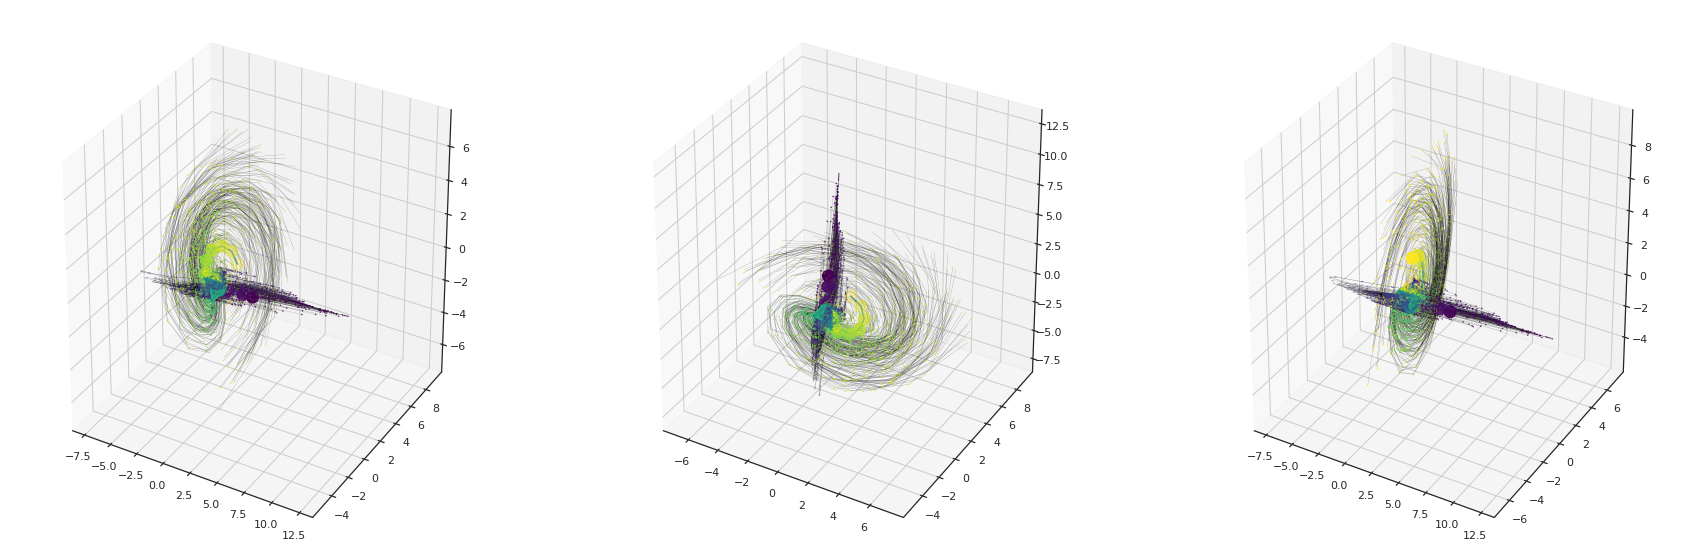

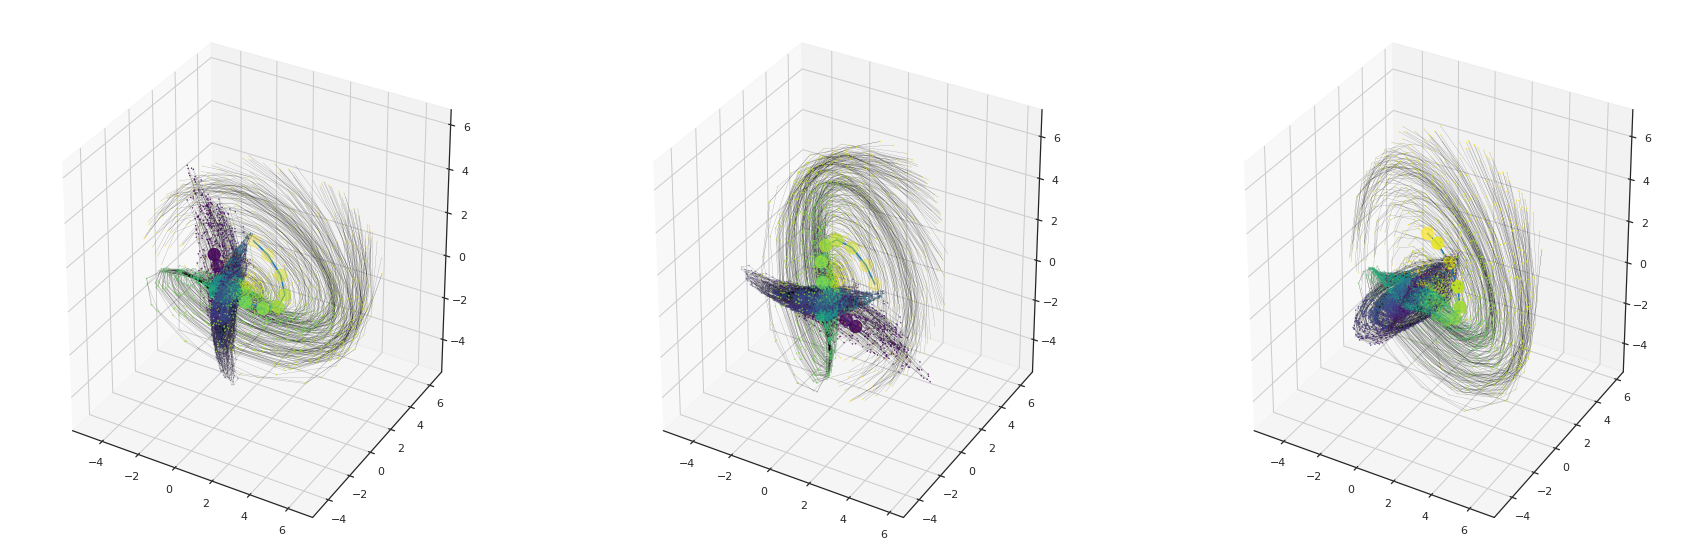

In [35]:
ncmp = 3

# input data
tpc = ut.get_pca_time_series(x, ncmp=3)
# factors
tpc_fac = ut.get_pca_time_series(factors, ncmp=3)

print(tpc.shape, tpc_fac.shape)

iplot = np.random.randint(tpc.shape[0], size=(300,))
ut.plot_3d_pca(tpc, iplot)
ut.plot_3d_pca(tpc_fac, iplot)